In [1]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from pandas_profiling import ProfileReport

sns.set()

# Context
The data we will be using through the pratical classes comes from a small relational database whose schema can be seen below:
![alt text](../figures/schema.png "Relation database schema")

# Reading the Data

In [2]:
# path to database
my_path = os.path.join("..", "data", "datamining.db")

# connect to the database
conn = sqlite3.connect(my_path)

# the query
query = """
select
    age, 
    income, 
    frq, 
    rcn, 
    mnt, 
    clothes, 
    kitchen, 
    small_appliances, 
    toys, 
    house_keeping,
    dependents, 
    per_net_purchase,
    g.gender, 
    e.education, 
    m.status, 
    r.description
from customers as c
    join genders as g on g.id = c.gender_id
    join education_levels as e on e.id = c.education_id
    join marital_status as m on m.id = c.marital_status_id
    join recommendations as r on r.id = c.recommendation_id
order by c.id;
"""

df = pd.read_sql_query(query, conn)

## Make a copy of your original dataset

why?

In [3]:
df_original = df.copy()

# Metadata
- *id* - The unique identifier of the customer
- *age* - The year of birht of the customer
- *income* - The income of the customer
- *frq* - Frequency: number of purchases made by the customer
- *rcn* - Recency: number of days since last customer purchase
- *mnt* - Monetary: amount of € spent by the customer in purchases
- *clothes* - Number of clothes items purchased by the customer
- *kitchen* - Number of kitchen items purchased by the customer
- *small_appliances* - Number of small_appliances items purchased by the customer
- *toys* - Number of toys items purchased by the customer
- *house_keeping* - Number of house_keeping items purchased by the customer
- *dependents* - Binary. Whether or not the customer has dependents
- *per_net_purchase* - Percentage of purchases made online
- *education* - Education level of the customer
- *status* - Marital status of the customer
- *gender* - Gender of the customer
- *description* - Last customer's recommendation description

## Problems:
- Duplicates?
- Data types?
- Missing values?
- Strange values?
- Descriptive statistics?

### Take a closer look and point out possible problems:

(hint: a missing values in pandas is represented with a NaN value)

In [4]:
# replace "" by nans
df.replace("", np.nan, inplace=True)

In [5]:
# check dataset data types again
df.dtypes

age                   int64
income              float64
frq                   int64
rcn                   int64
mnt                   int64
clothes               int64
kitchen               int64
small_appliances      int64
toys                  int64
house_keeping         int64
dependents          float64
per_net_purchase      int64
gender               object
education            object
status               object
description          object
dtype: object

In [6]:
# check descriptive statistics again
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,8998.0,NaN,NaN,NaN,1966.05968,17.296552,1936.0,1951.0,1966.0,1981.0,1996.0
income,8952.0,NaN,NaN,NaN,69963.550827,27591.556226,10000.0,47741.0,70030.5,92218.0,140628.0
frq,8998.0,NaN,NaN,NaN,19.848077,10.903435,3.0,10.0,17.0,28.0,59.0
rcn,8998.0,NaN,NaN,NaN,62.469771,69.761802,0.0,26.0,53.0,79.0,549.0
mnt,8998.0,NaN,NaN,NaN,622.162814,646.768205,6.0,63.0,383.0,1076.0,3052.0
clothes,8998.0,NaN,NaN,NaN,50.446655,23.422249,1.0,33.0,51.0,69.0,99.0
kitchen,8998.0,NaN,NaN,NaN,7.039675,7.848139,0.0,2.0,4.0,10.0,75.0
small_appliances,8998.0,NaN,NaN,NaN,28.524116,12.586437,1.0,19.0,28.0,37.0,74.0
toys,8998.0,NaN,NaN,NaN,7.036897,7.924422,0.0,2.0,4.0,10.0,62.0
house_keeping,8998.0,NaN,NaN,NaN,6.929984,7.882655,0.0,2.0,4.0,9.0,77.0


In [7]:
# Define metric and non-metric features. Why? --> missing values are filled in a different way
non_metric_features = ["education", "status", "gender", "dependents", "description"]
metric_features = df.columns.drop(non_metric_features).to_list()

## Fill missing values (Data imputation)

How can we fill missing values?

In [8]:
# Creating a copy to apply central tendency measures imputation
df_central = df.copy()

In [9]:
# count of missing values
df_central.isna().sum()

age                   0
income               46
frq                   0
rcn                   0
mnt                   0
clothes               0
kitchen               0
small_appliances      0
toys                  0
house_keeping         0
dependents          282
per_net_purchase      0
gender                0
education            47
status              177
description           0
dtype: int64

In [10]:
df_central.median()
# mean or mode

# Median when we have outliers
# Mean when we do not have outliers (mean is very sensitive to outliers)

age                  1966.0
income              70030.5
frq                    17.0
rcn                    53.0
mnt                   383.0
clothes                51.0
kitchen                 4.0
small_appliances       28.0
toys                    4.0
house_keeping           4.0
dependents              1.0
per_net_purchase       45.0
dtype: float64

In [11]:
modes = df_central[non_metric_features].mode().loc[0]
modes

education      Graduation
status            Married
gender                  M
dependents            1.0
description      OK nice!
Name: 0, dtype: object

In [12]:
df_central.fillna(df_central.median(), inplace=True)
df_central.fillna(modes, inplace=True)

df_central.isna().sum()  # checking how many NaNs we still have

age                 0
income              0
frq                 0
rcn                 0
mnt                 0
clothes             0
kitchen             0
small_appliances    0
toys                0
house_keeping       0
dependents          0
per_net_purchase    0
gender              0
education           0
status              0
description         0
dtype: int64

In [13]:
modes = df_central[non_metric_features].mode().loc[0]
medians = df_central[metric_features].median()

na_values = pd.concat([modes, medians])

df_central.fillna(na_values, inplace = True)
df_central.isna().sum()

age                 0
income              0
frq                 0
rcn                 0
mnt                 0
clothes             0
kitchen             0
small_appliances    0
toys                0
house_keeping       0
dependents          0
per_net_purchase    0
gender              0
education           0
status              0
description         0
dtype: int64

<AxesSubplot:ylabel='Frequency'>

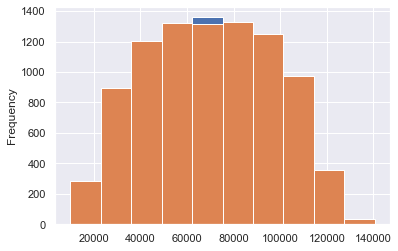

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

df_central['income'].plot.hist()
df['income'].plot.hist()

In [15]:
# Creating new df copy to explore neighbordhood imputation
df_neighbors = df.copy()

In [16]:
# Seeing rows with NaNs
nans_index = df_neighbors.isna().any(axis=1)
df_neighbors[nans_index]

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,dependents,per_net_purchase,gender,education,status,description
3,1955,93571.0,26,10,888,60,10,19,6,5,1.0,35,F,Master,NaN,OK nice!
61,1968,NaN,14,90,184,95,1,3,1,0,1.0,59,F,2nd Cycle,Married,Meh...
67,1981,60457.0,9,73,63,37,2,51,6,3,NaN,57,M,PhD,Married,Meh...
70,1944,116259.0,28,35,1279,17,6,54,3,20,0.0,11,M,Graduation,NaN,OK nice!
73,1967,75274.0,16,67,263,88,3,6,1,2,NaN,66,M,Graduation,Single,Kind of OK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8932,1959,NaN,20,71,716,67,5,25,3,1,0.0,27,M,Graduation,Married,Meh...
8942,1950,92746.0,34,98,1399,50,5,36,5,4,NaN,28,M,Master,Married,Take my money!!
8964,1978,44661.0,6,49,33,18,18,35,16,13,1.0,42,M,1st Cycle,NaN,OK nice!
8972,1976,NaN,17,9,254,70,1,28,1,1,1.0,59,M,Graduation,Divorced,Meh...


In [17]:
# KNNImputer - only works for numerical varaibles!!
imputer = KNNImputer(n_neighbors=5, weights="uniform")

df_neighbors[metric_features] = imputer.fit_transform(df_neighbors[metric_features])

In [18]:
# See rows with NaNs imputed
df_neighbors.loc[nans_index, metric_features]

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase
3,1955.0,93571.0,26.0,10.0,888.0,60.0,10.0,19.0,6.0,5.0,35.0
61,1968.0,63143.0,14.0,90.0,184.0,95.0,1.0,3.0,1.0,0.0,59.0
67,1981.0,60457.0,9.0,73.0,63.0,37.0,2.0,51.0,6.0,3.0,57.0
70,1944.0,116259.0,28.0,35.0,1279.0,17.0,6.0,54.0,3.0,20.0,11.0
73,1967.0,75274.0,16.0,67.0,263.0,88.0,3.0,6.0,1.0,2.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...
8932,1959.0,85643.4,20.0,71.0,716.0,67.0,5.0,25.0,3.0,1.0,27.0
8942,1950.0,92746.0,34.0,98.0,1399.0,50.0,5.0,36.0,5.0,4.0,28.0
8964,1978.0,44661.0,6.0,49.0,33.0,18.0,18.0,35.0,16.0,13.0,42.0
8972,1976.0,63932.4,17.0,9.0,254.0,70.0,1.0,28.0,1.0,1.0,59.0


In [19]:
# let's keep the central imputation
df = df_central.copy()

## An overview of our previous data exploration

You can also explore this dataset using the exported `pandas-profiling` report.



![](../figures/exp_analysis/categorical_variables_frequecies.png)

![](../figures/exp_analysis/numeric_variables_histograms.png)

![](../figures/exp_analysis/numeric_variables_boxplots.png)

![](../figures/exp_analysis/pairwise_relationship_of_numerical_variables.png)

![](../figures/exp_analysis/correlation_matrix.png)

## Outlier removal

Why do we need to remove outliers? Which methods can we use?


Let's start by "manually" filtering the dataset's outliers

In [20]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

filters1 = (
    (df['house_keeping']<=50)
    &
    (df['kitchen']<=40)
    &
    (df['toys']<=35)
    &
    (df['education']!='OldSchool')
)

df_1 = df[filters1]

In [21]:
print(f'Percentage of data kept after removing outliers: {np.round(df_1.shape[0] / df_original.shape[0] *100, 2)} %')

Percentage of data kept after removing outliers: 97.99 %


### Outlier removal using only the IQR method

Why should you use/not use this method?

In [26]:
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters = []

for metric in metric_features:
    
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    
    filters.append(df[metric].between(llim, ulim, inclusive=True))

filter2 = np.all(filters, 0)
df_2 = df[filter2]

print(f'Percentage of data kept after removing outliers: {np.round(df_2.shape[0] / df_original.shape[0] *100, 2)} %')

Percentage of data kept after removing outliers: 82.42 %


What do you think about this percentage?

## Combining different outlier methods

More robust/ consistent outlier detection method:

In [27]:
df_3 = df[(filters1 | filter2)]
print(f'Percentage of data kept after removing outliers: {np.round(df_3.shape[0] / df_original.shape[0] *100, 2)} %')

Percentage of data kept after removing outliers: 98.19 %


In [ ]:
# Get the manual filtering version
df = df_1.copy()

## Feature Engineering

A reminder of our metadata:
- *id* - The unique identifier of the customer
- *age* - The year of birht of the customer
- *income* - The income of the customer
- *frq* - Frequency: number of purchases made by the customer
- *rcn* - Recency: number of days since last customer purchase
- *mnt* - Monetary: amount of € spent by the customer in purchases
- *clothes* - Number of clothes items purchased by the customer
- *kitchen* - Number of kitchen items purchased by the customer
- *small_appliances* - Number of small_appliances items purchased by the customer
- *toys* - Number of toys items purchased by the customer
- *house_keeping* - Number of house_keeping items purchased by the customer
- *dependents* - Binary. Whether or not the customer has dependents
- *per_net_purchase* - Percentage of purchases made online
- *education* - Education level of the customer
- *status* - Marital status of the customer
- *gender* - Gender of the customer
- *description* - Last customer's recommendation description

In [ ]:
datetime.now()#.year

In [ ]:
#df.rename(columns={'age':'birth_year'}, inplace=True)
df['birth_year'] = df['age']
df['age'] = datetime.now().year - df['birth_year']

df.head()

In [ ]:
df['spent_online'] = df['per_net_purchase'] * df['mnt'] / 100
df.head()

In [ ]:
# How can we avoid having as many extreme values in 'rcn'?
print((df['rcn']>100).value_counts())

rcn_t = df['rcn'].copy()
rcn_t.loc[rcn_t>100] = 100

df['rcn'] = rcn_t

print()
print((df['rcn']>100).value_counts())

## Variable selection: Redundancy VS Relevancy

### Redundancy
We already saw our original correlation matrix:
![](../figures/exp_analysis/correlation_matrix.png)

In [ ]:
# Select variables according to their correlations
df.drop(columns=['birth_year', 'age', 'mnt'], inplace=True)

In [ ]:
# Updating metric_features
metric_features.append("spent_online")
metric_features.remove("mnt")
metric_features.remove("age")

### Relevancy
Selecting variables based on the relevancy of each one to the task. Example: remove uncorrelated variables with the target, stepwise regression, use variables for product clustering, use variables for socio-demographic clustering, ...

Variables that aren't correlated with any other variable are often also not relevant. In this case we will not focus on this a lot since we don't have a defined task yet.

## Data Normalization

In [ ]:
df_minmax = df.copy()

In [ ]:
# Use MinMaxScaler to scale the data
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_minmax[metric_features])
scaled_feat

In [ ]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n", scaler.data_min_, "\n", scaler.data_max_)

In [ ]:
df_minmax[metric_features] = scaled_feat
df_minmax.head()

In [ ]:
# Checking max and min of minmaxed variables
df_minmax[metric_features].describe().round(2).T

In [ ]:
df_standard = df.copy()

In [ ]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_standard[metric_features])
scaled_feat

In [ ]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n", scaler.mean_, "\n", scaler.var_)

In [ ]:
df_standard[metric_features] = scaled_feat
df_standard.head()

In [ ]:
# Checking mean and variance of standardized variables
df_standard[metric_features].describe().round(2).T

**Important**: What if we had a training and test set? Should we fit a Scaler in both? What about other Sklearn objects?

In [ ]:
df = df_standard.copy()

## One-hot encoding

In [ ]:
df_ohc = df.copy()

In [ ]:
df['status'].mode()#[0]

In [ ]:
# First let's remove status=Whatever
df_ohc.loc[df_ohc['status'] == 'Whatever', 'status'] = df['status'].mode()[0]

In [ ]:
# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False, drop="first")

ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])

ohc_feat_names = ohc.get_feature_names()

ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
ohc_df

In [ ]:
# Reassigning df to contain ohc variables
# Concat metrics with non metrics
df_ohc = pd.concat([df_ohc.drop(columns=non_metric_features), ohc_df], axis=1)
df_ohc

In [ ]:
df = df_ohc.copy()